In [1]:
import time, os

# Numpy
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev as C
from numpy import polynomial as P

import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from datetime import datetime



import IPython
from IPython.display import display, Image
import ipywidgets as widgets
from tqdm import tqdm
import pytz # Python Timezone


2022-02-03 15:46:16.792808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-03 15:46:16.792853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The code below serves to create the dataset in .npy files which is the way I designed it. If you want to download the same dataset, you can do it on the following link: [CheXpert Dataset](https://stanfordmlgroup.github.io/competitions/chexpert/) 

In [ ]:
def create_dataset(loc=""):
    # Reading CSV
    prefix = loc + "CheXpert-v1.0-small"
    train = pd.read_csv(prefix + "/train.csv") # dataframe
    valid = pd.read_csv(prefix + "/valid.csv") # dataframe
    #train["Path"] = train["Path"].apply(lambda x: x.replace("CheXpert-v1.0-small", "chexpert"))
    #valid["Path"] = valid["Path"].apply(lambda x: x.replace("CheXpert-v1.0-small", "chexpert"))
    
    train_labels = []
    for path in tqdm(train["Path"]):
        if "frontal" in path:
            train_labels.append(1)
        elif "lateral" in path:
            train_labels.append(0)
        else:
            print("ERROR:", path)  

    train_labels = np.array(train_labels)
    count_lateral = (train_labels == 0).sum()
    count_frontal = (train_labels == 1).sum()
    print("Lateral: ", count_lateral , "Frontal: ", count_frontal, "Total: ", count_frontal + count_lateral)
    
    train_img = []
    train_labels = []
    test_img = []
    test_label = []
    new_count_frontal = 0
    
    for path in tqdm(train["Path"]):
        if "frontal" in path:
            if new_count_frontal < count_lateral:
                train_labels.append(1)
                new_count_frontal += 1
            else:
                test_labels.append(0)
                image = PIL.Image.open(path)
                image = image.resize((128, 128))
                test_img.append(np.asarray(image))
                continue 
        elif "lateral" in path:
            train_labels.append(0)

        else: 
            print("Should not be getting here")
            continue

        image = PIL.Image.open(path)
        image = image.resize((128, 128))
        train_img.append(np.asarray(image))
    
    train_img = np.array(train_img)
    train_labels = np.array(train_labels)
    test_img = np.array(test_img)
    test_label = np.array(test_label)
    
    valid_img = []
    valid_labels = []
    
    for path in tqdm(valid["Path"]):
        if "frontal" in path:
            valid_labels.append(1)
        elif "lateral" in path:
            valid_labels.append(0)

        else: 
            continue

        image = PIL.Image.open(path)
        image = image.resize((128, 128))
        valid_img.append(np.asarray(image))
    
    valid_img = np.array(valid_img)
    valid_labels = np.array(valid_labels)

    np.save(loc + 'train_img.npy', train_img)
    np.save(loc + 'train_labels.npy', train_labels)
    np.save(loc + 'valid_img.npy', valid_img)
    np.save(loc + 'valid_labels.npy', valid_labels)
    np.save(loc + 'test_img.npy', test_img)
    np.save(loc + 'test_labels.npy', test_labels)
    
#create_dataset("./data/dataset/")

The code below loads the .npy files to memory, in the format used for the code.

In [5]:
def load_dataset(loc=""):
    def preprocess(x):
        x = x.astype(np.float32) / 255 # gray scale to floating point
        x = np.expand_dims(x, axis=3)
        return x
    x_train = np.load(loc + 'train_img.npy')
    x_train = preprocess(x_train)
    y_train = np.load(loc + 'train_labels.npy')
    
    x_val = np.load(loc + 'valid_img.npy')
    x_val= preprocess(x_val)
    
    y_val = np.load(loc + 'valid_labels.npy')
    
    x_test = np.load(loc + 'test_img.npy')
    x_test = preprocess(x_test)
    
    y_test = np.load(loc + 'test_labels.npy')
    return x_train, y_train, x_val, y_val, x_test, y_test
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset("./dataset/")


The code below plots the images in two formats to better visualize the image ranges.

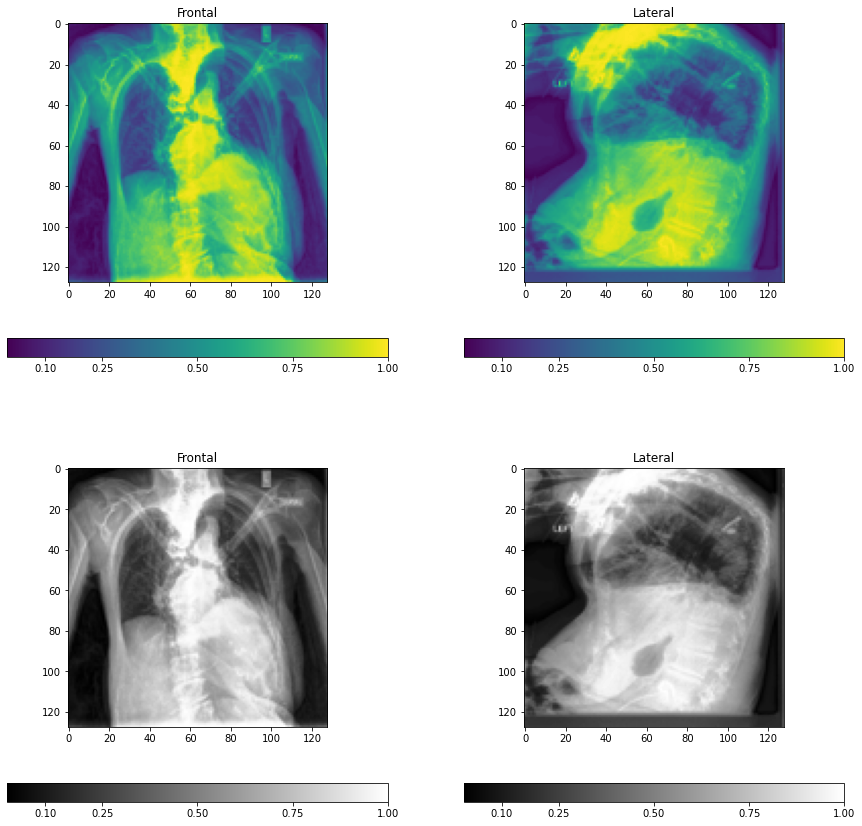

In [6]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(x_train[1])
ax.set_title('Frontal')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(x_train[3])
ax.set_title('Lateral')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(x_train[1], cmap='gray')
ax.set_title('Frontal')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(x_train[3], cmap='gray')
ax.set_title('Lateral')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')

In [13]:
y_train[2]

1

Decorator to create compile and save the models 

In [8]:
def compile_train_save(epochs = 10, batch_size = 64):
    def decorator(func):
        def wrapper():
            model = func()
            model.summary()
            def loss(labels, logits):
                return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)

            optimizer = SGD(learning_rate=0.008, momentum=0.9)
            model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
            hist = model.fit(x_train, y_train, 
                  epochs=epochs, batch_size=batch_size, 
                  validation_data=(x_val, y_val), 
                  verbose=1)
            model.save("model/%s[%f][%f]-" % (func.__name__, hist.history['accuracy'][-1],hist.history['val_accuracy'][-1]) + ".h5")
            return model

        return wrapper
    return decorator

Although the code below defines a Neural Network, the architecture is this of a Logistic Regression with just a one neuron multilayer perceptron.

In [9]:
@compile_train_save(epochs = 5)
def Logistic_Regression():
    # 2. Model Construction
    model = Sequential()
    model.add(Flatten(input_shape=(128,128,1)))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = Logistic_Regression()


2022-02-03 15:57:22.279832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-03 15:57:22.280263: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 15:57:22.280320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab): /proc/driver/nvidia/version does not exist
2022-02-03 15:57:22.280903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1)                 16385     
                                                                 
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________


2022-02-03 15:57:22.355720: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4245028864 exceeds 10% of free system memory.
/home/jocabrer/anaconda3/envs/anacondo/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1/5
1013/1013 [==============================] - 3s 2ms/step - loss: 0.1181 - accuracy: 0.9809 - val_loss: 0.0114 - val_accuracy: 0.9915
Epoch 2/5
1013/1013 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9845 - val_loss: 0.0213 - val_accuracy: 0.9872
Epoch 3/5
1013/1013 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9850 - val_loss: 0.0149 - val_accuracy: 0.9915
Epoch 4/5
1013/1013 [==============================] - 2s 2ms/step - loss: 0.0517 - accuracy: 0.9863 - val_loss: 0.0411 - val_accuracy: 0.9872
Epoch 5/5
1013/1013 [==============================] - 2s 2ms/step - loss: 0.0463 - accuracy: 0.9868 - val_loss: 0.0231 - val_accuracy: 0.9915


In [10]:
def loss(labels, logits):
    return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)

The code below defines how we test the models

In [12]:
def test_models():
    get_custom_objects().update({"loss": loss,
                            })
    for path in glob.glob("model/*.h5"):
        new_model = tf.keras.models.load_model(path)
        print(path)
        print("Training Accuracy:")
        new_model.evaluate(x_train, y_train)
        print("Test Accuracy:")
        new_model.evaluate(x_test, y_test)
test_models()

model/lr.h5
Training Accuracy:
   1/2025 [..............................] - ETA: 5:21 - loss: 0.0053 - accuracy: 1.0000

2022-02-03 15:57:43.147702: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4245028864 exceeds 10% of free system memory.


2025/2025 [==============================] - 3s 1ms/step - loss: 0.0401 - accuracy: 0.9899
Test Accuracy:
8/8 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9915
model/Logistic_Regression[0.986522][0.991453]-.h5
Training Accuracy:
   1/2025 [..............................] - ETA: 4:41 - loss: 0.0155 - accuracy: 1.0000

2022-02-03 15:57:47.833308: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4245028864 exceeds 10% of free system memory.


2025/2025 [==============================] - 3s 1ms/step - loss: 0.0374 - accuracy: 0.9891
Test Accuracy:
8/8 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9915
model/Logistic_Regression[0.985750][0.995726]-.h5
Training Accuracy:
   1/2025 [..............................] - ETA: 4:12 - loss: 0.0861 - accuracy: 0.9688

2022-02-03 15:57:52.465732: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4245028864 exceeds 10% of free system memory.


2025/2025 [==============================] - 3s 1ms/step - loss: 0.0395 - accuracy: 0.9893
Test Accuracy:
8/8 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9957
model/Logistic_Regression[0.986754][0.991453]-.h5
Training Accuracy:
   1/2025 [..............................] - ETA: 4:32 - loss: 0.0053 - accuracy: 1.0000

2022-02-03 15:57:57.161313: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4245028864 exceeds 10% of free system memory.


2025/2025 [==============================] - 3s 1ms/step - loss: 0.0429 - accuracy: 0.9876
Test Accuracy:
8/8 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9915


In [ ]:
def loss(labels, logits):
    return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)
get_custom_objects().update({"loss": loss})
new_model = tf.keras.models.load_model("model/Logistic_Regression[0.986167][0.991453]-Mon Jan 31 10:15:08 2022.h5")